In [27]:
from sortedcontainers import SortedList
from fractions import Fraction
from functools import total_ordering

import numpy as np
import pylab as pl
from matplotlib import collections as mc
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d


from utillities.test_utilities import run_tests_params


In [28]:
from dataclasses import dataclass


@dataclass(order=True, frozen=True, slots=True)
class Point:
    x: float = 0.0
    y: float = 0.0

    def __add__(self, other: 'Point'):
        return Point(self.x + other.x, self.y + other.y)

    def __sub__(self, other: 'Point'):
        return Point(self.x - other.x, self.y - other.y)

    def __truediv__(self, other):
        if isinstance(other, int):
            return Point(self.x / other, self.y / other)
        return NotImplemented

    def __floordiv__(self, other):
        if isinstance(other, int):
            return Point(self.x // other, self.y // other)
        return NotImplemented


```
Algorithm CONVEXHULL(P)
Input. A set P of points in the plane.
Output. A list 𝓛 containing the vertices of 𝓒𝓗(P) in clockwise order.
1. Sort the points by x-coordinate, resulting in a sequence p1,..., pn.
2. Put the points p1 and p2 in a list 𝓛upper, with p1 as the first point.
3. for i ← 3 to n
4.    do Append pi to 𝓛upper.
5.       while 𝓛upper contains more than two points and the last 
               three points in Lupper do not make a right turn
6.          do Delete the middle of the last three points from 𝓛upper.
7. Put the points pn and pn−1 in a list 𝓛lower 6 , with pn as the first point.
8. for i ← n−2 downto 1
9.       do Append pi to Llower.
10.         while 𝓛lower contains more than 2 points and the last 
                three points in Llower do not make a right turn
11.            do Delete the middle of the last three points from 𝓛lower.
12. Remove the first and the last point from 𝓛lower to avoid duplication of the points where the upper and lower hull meet.
13. Append 𝓛lower to 𝓛upper, and call the resulting list 𝓛.
14. return 𝓛
```


In [29]:
def last_three_points_make_no_right_turn(P: list[Point]) -> bool:
    p_1, p_2, p_3 = P[-3:]
    determant = (p_2.x - p_1.x) * (p_3.y - p_1.y)
    determant -= (p_2.y - p_1.y) * (p_3.x - p_1.x)
    return determant >= 0


def convexhull(P: list[Point]) -> list[Point]:
    P.sort()
    n = len(P)
    Lupper = [P[0], P[1]]
    for i in range(2, n):
        Lupper.append(P[i])
        while len(Lupper) > 2 and last_three_points_make_no_right_turn(Lupper):
            Lupper.pop(-2)

    Llower = [P[-1], P[-2]]
    for i in range(n - 3, -1, -1):
        Llower.append(P[i])
        while len(Llower) > 2 and last_three_points_make_no_right_turn(Llower):
            Llower.pop(-2)

    return Lupper + Llower[1:-1]


In [30]:
tests = [
    {
        'name': 'Test 1',
        'P': [
            Point(0, 3), Point(1, 1), Point(2, 2),
        ],
        'expected': [
            Point(0, 3), Point(1, 1), Point(2, 2)
        ],
    },
    {
        'name': 'Test 2',
        'P': [
            Point(0, 0), Point(0, 2), Point(2, 2), Point(2, 0),
        ],
        'expected': [
            Point(0, 0), Point(0, 2), Point(2, 2), Point(2, 0),
        ],
    },
    {
        'name': 'Test 3',
        'P': [
            Point(0, 3), Point(1, 1), Point(2, 2), Point(1, 2),
        ],
        'expected': [
            Point(0, 3), Point(1, 1), Point(2, 2)
        ],
    },
    {
        'name': 'Test 4',
        'P': [
            Point(0, 3), Point(1, 1), Point(2, 2), Point(4, 4),
            Point(0, 0), Point(1, 2), Point(3, 1), Point(3, 3),
        ],
        'expected': [
            Point(4, 4), Point(0, 3), Point(0, 0), Point(3, 1),
        ],
    },
]


run_tests_params(convexhull, tests, lambda l, r: sorted(l) == sorted(r))



Test Test 1 passed, for convexhull.
Test Test 2 passed, for convexhull.
Test Test 3 passed, for convexhull.
Test Test 4 passed, for convexhull.
Success


In [31]:
def determine_centroid(P):
    return sum(P, start=Point(0, 0)) // len(P)


def sort_in_clockwise_order(P):
    c = determine_centroid(P)
    return sorted(P, key=lambda p: p - c)


def r_lies_to_the_left_op_p_to_q(a, b, c):
    return ((b.x - a.x) * (c.y - a.y) - (b.y - a.y) * (c.x - a.x)) > 0


In [32]:
from itertools import product


def slow_convexhull(P):
    E = set()
    for p, q in product(P, repeat=2):
        if p is q: continue
        valid = True
        for r in P:
            if r is p or r is q: continue
            valid &= r_lies_to_the_left_op_p_to_q(p, q, r)
        if valid:
            E.add(p)
            E.add(q)

    return sort_in_clockwise_order(E)

In [33]:
run_tests_params(slow_convexhull, tests, lambda l, r: sorted(l) == sorted(r))



Test Test 1 passed, for slow_convexhull.
Test Test 2 passed, for slow_convexhull.
Test Test 3 passed, for slow_convexhull.
Test Test 4 passed, for slow_convexhull.
Success


In [34]:
def print_points_and_convexhull(P):
    points = np.array([(p.x, p.y) for p in P])
    centroid = determine_centroid(P)

    
    plt.plot(centroid.x, centroid.y, 'go')
    plt.text(centroid.x, centroid.y, f' {centroid}')
    hull = ConvexHull(points)

    plt.plot(points[:, 0], points[:, 1], 'o')
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

    plt.show()
    return [P[i] for i in hull.vertices]


def ch(P):
    if len(P) < 3: return sorted(P)
    return ConvexHull(np.array([(p.x, p.y) for p in P]))


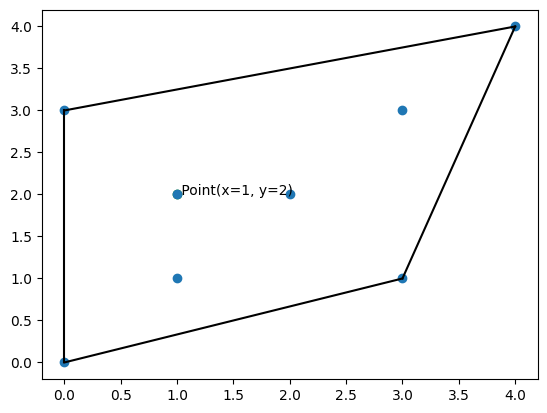

[Point(x=4, y=4), Point(x=0, y=3), Point(x=0, y=0), Point(x=3, y=1)]

In [35]:
print_points_and_convexhull([
    Point(0, 3), Point(1, 1), Point(2, 2), Point(4, 4),
    Point(0, 0), Point(1, 2), Point(3, 1), Point(3, 3),
])


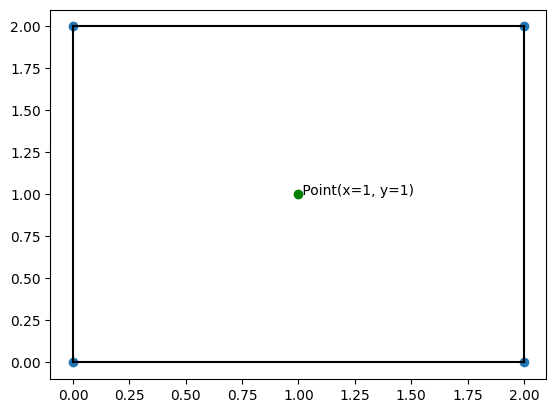

[Point(x=0, y=2), Point(x=0, y=0), Point(x=2, y=0), Point(x=2, y=2)]

In [36]:
print_points_and_convexhull([
    Point(0, 0), Point(0, 2), Point(2, 2), Point(2, 0),
])

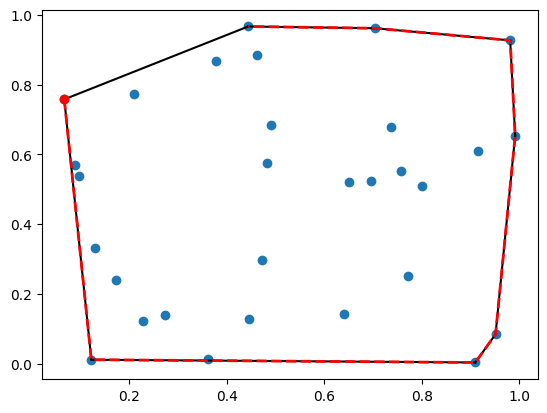

In [37]:
rng = np.random.default_rng()
points = rng.random((30, 2))   # 30 random points in 2-D
hull = ConvexHull(points)

plt.plot(points[:, 0], points[:, 1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

plt.plot(points[hull.vertices, 0], points[hull.vertices, 1], 'r--', lw=2)
plt.plot(points[hull.vertices[0], 0], points[hull.vertices[0], 1], 'ro')
plt.show()


In [38]:
rng.random((3, 2))


array([[0.0813998 , 0.79754877],
       [0.65826072, 0.10080575],
       [0.48270779, 0.13443772]])

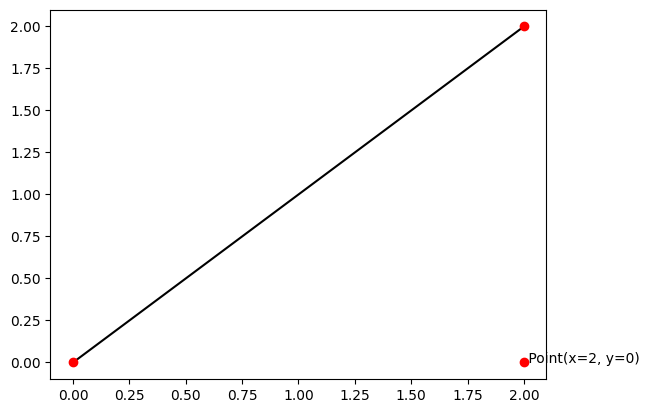

False

In [39]:
def print_line_and_point(a, b, c):
    plt.plot((a.x, b.x), (a.y, b.y), 'k-')
    plt.plot((a.x, b.x, c.x), (a.y, b.y, c.y), 'ro')
    plt.text(c.x, c.y, f' {c}')

    plt.show()


a = Point(0, 0)
b = Point(2, 2)
c = Point(2, 0)


print_line_and_point(a, b, c)
r_lies_to_the_left_op_p_to_q(a, b, c)
